# Data

In [1]:
from tensorflow.keras.models import load_model
import kagglehub #allows users to access various Kaggle resources
import tensorflow as tf
import numpy as np
import os
import shutil
import random
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array, load_img, array_to_img



In [2]:
def create_clean_dir(directory):
    """Creates a directory after removing any existing one."""
    shutil.rmtree(directory, ignore_errors=True)
    os.makedirs(directory, exist_ok=True)

# Download the dataset
dataset_name = "mengcius/cinic10"
path = kagglehub.dataset_download(dataset_name)

# Define paths for training, validation, and testing
train_dir = os.path.join(path, "train")
valid_dir = os.path.join(path, "valid")
test_dir = os.path.join(path, "test")

# Define small dataset directories
maly_zbior = os.path.join("/kaggle/working", "maly_zbior")
maly_zbior_test = os.path.join("/kaggle/working", "maly_zbior_test")

# Create or reset directories
create_clean_dir(maly_zbior)
create_clean_dir(maly_zbior_test)

# Print dataset paths
print(f"Downloaded dataset from Kaggle: {dataset_name}")
print(f"Path to dataset: {path}")
print(f"Path to small dataset (maly_zbior): {maly_zbior}")
print(f"Path to small test dataset (maly_zbior_test): {maly_zbior_test}")


100%|██████████| 754M/754M [00:07<00:00, 104MB/s]

Extracting files...


Downloaded dataset from Kaggle: mengcius/cinic10
Path to dataset: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/1
Path to small dataset (maly_zbior): /kaggle/working/maly_zbior
Path to small test dataset (maly_zbior_test): /kaggle/working/maly_zbior_test


In [3]:
class_names = sorted(os.listdir(test_dir))
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Augmentation presentation


In [7]:
import cv2

#Stretch image
def stretch_image(image, stretch_factor=None, interpolation=cv2.INTER_LINEAR):
    h, w = image.shape[:2]

    if stretch_factor is None:
        stretch_factor = np.random.uniform(0.8, 1.2)  # Bezpieczny zakres
    elif isinstance(stretch_factor, (list, tuple)):
        stretch_factor = np.random.uniform(stretch_factor[0], stretch_factor[1])

    new_w = int(w * stretch_factor)
    new_h = int(h * (1 / stretch_factor))

    stretched = cv2.resize(image, (new_w, new_h), interpolation=interpolation)


    if new_w > w:
        x_start = (new_w - w) // 2
        stretched = stretched[:, x_start:x_start + w]
    if new_h > h:
        y_start = (new_h - h) // 2
        stretched = stretched[y_start:y_start + h, :]

    stretched = cv2.resize(stretched, (w, h), interpolation=interpolation)
    stretched = cv2.cvtColor(stretched, cv2.COLOR_BGR2RGB)

    return stretched


#Flip image
def flip(img):
  img_array = img_to_array(img)

  flipped_img_array = np.fliplr(img_array)

  flipped_img = flipped_img_array.astype(np.uint8)
  flipped_img = cv2.cvtColor(cv2.flip(flipped_img, 1), cv2.COLOR_BGR2RGB)

  return flipped_img

#Sobel image
def apply_sobel(image):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)

    sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))

    sobel_combined = cv2.cvtColor(sobel_combined, cv2.COLOR_GRAY2RGB)
    return sobel_combined

#Rotate image
def rotate_image(image, angle):

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
    return rotated_image

# To sepia
def to_sepia(image):

    if image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    image = image.astype(np.float32) / 255

    # Apply Sepia filter
    sepia_filter = np.array([[0.272, 0.534, 0.131],
                              [0.349, 0.686, 0.168],
                              [0.393, 0.769, 0.189]])

    sepia_image = np.dot(image, sepia_filter.T)
    sepia_image = np.clip(sepia_image, 0, 1)

    sepia_image = (sepia_image * 255).astype(np.uint8)

    return sepia_image

#To balck & white
def to_grayscale(image):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return gray_rgb

#Crop image
def crop_image(image):
    h, w = image.shape[:2]
    crop_size = np.random.randint(24, 32)
    x = np.random.randint(0, w - crop_size)
    y = np.random.randint(0, h - crop_size)
    cropped = image[y:y+crop_size, x:x+crop_size]
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    return cv2.resize(cropped, (w, h))

# Gaussian Noise
def add_gaussian_noise(image):

    mean = 0
    stddev = 1
    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)
    return np.clip(noisy_image, 0, 255)

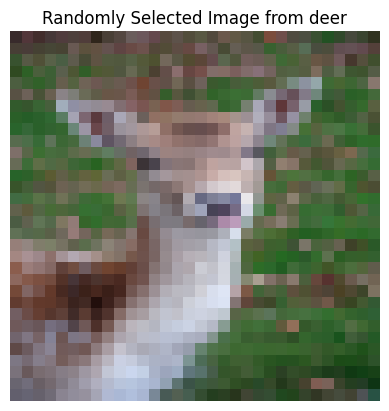

In [8]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the path to the train directory
train_dir = path + "/train"

# Get a list of all class directories
class_dirs = [os.path.join(train_dir, class_name) for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))]

# Choose a random class
random_class_dir = random.choice(class_dirs)

# Get a list of images in the chosen class directory
image_files = [f for f in os.listdir(random_class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Choose a random image
random_image_path = os.path.join(random_class_dir, random.choice(image_files))

# Load the image using OpenCV
image = cv2.imread(random_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display in matplotlib

# Show the selected image
plt.imshow(image)
plt.axis("off")
plt.title(f"Randomly Selected Image from {os.path.basename(random_class_dir)}")
plt.show()


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_augmented_images(image, display_size=(64, 64)):
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for original image

    aug_images = [
        ("Rotation", rotate_image(image, 30)),
        ("Stretching", stretch_image(image)),
        ("Flipping", flip(image)),
        ("Cropping", crop_image(image)),
        ("Black&White", to_grayscale(image)),
        ("Sepia", to_sepia(image)),
        ("Gaussian Noise", add_gaussian_noise(image)),
        ("Sobel", apply_sobel(image))
    ]

    # Create a 2-row, 5-column grid (first column will span two rows for the original image)
    fig = plt.figure(figsize=(13, 6.5))
    grid = fig.add_gridspec(2, 5, height_ratios=[1, 1])  # The first row will be bigger for the original image

    # Place the original image spanning both rows in the first column
    ax0 = fig.add_subplot(grid[:2, 0])  # Take the first column across both rows
    ax0.imshow(image)
    ax0.set_title("Original", fontsize=11)
    ax0.axis("off")

    # Define positions for the small images in the grid (excluding the first column)
    positions = [(0, 1), (0, 2), (0, 3), (0, 4),  # First row small images
                 (1, 1), (1, 2), (1, 3), (1, 4)]  # Second row small images

    # Loop through the augmented images and place them in the remaining grid slots
    for (title, img), (row, col) in zip(aug_images, positions):

        img_resized = cv2.resize(img, display_size, interpolation=cv2.INTER_AREA)

        # If the image is grayscale, convert to RGB
        if len(img_resized.shape) == 2:  # Grayscale image
            img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

        # Convert the image to RGB (if BGR format) for proper display
        if img_resized.shape[-1] == 3:  # Check if the image has 3 channels
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)


        # Display image
        ax = fig.add_subplot(grid[row, col])
        ax.imshow(img_rgb)  # Display image in RGB format
        ax.set_title(title, fontsize=11)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


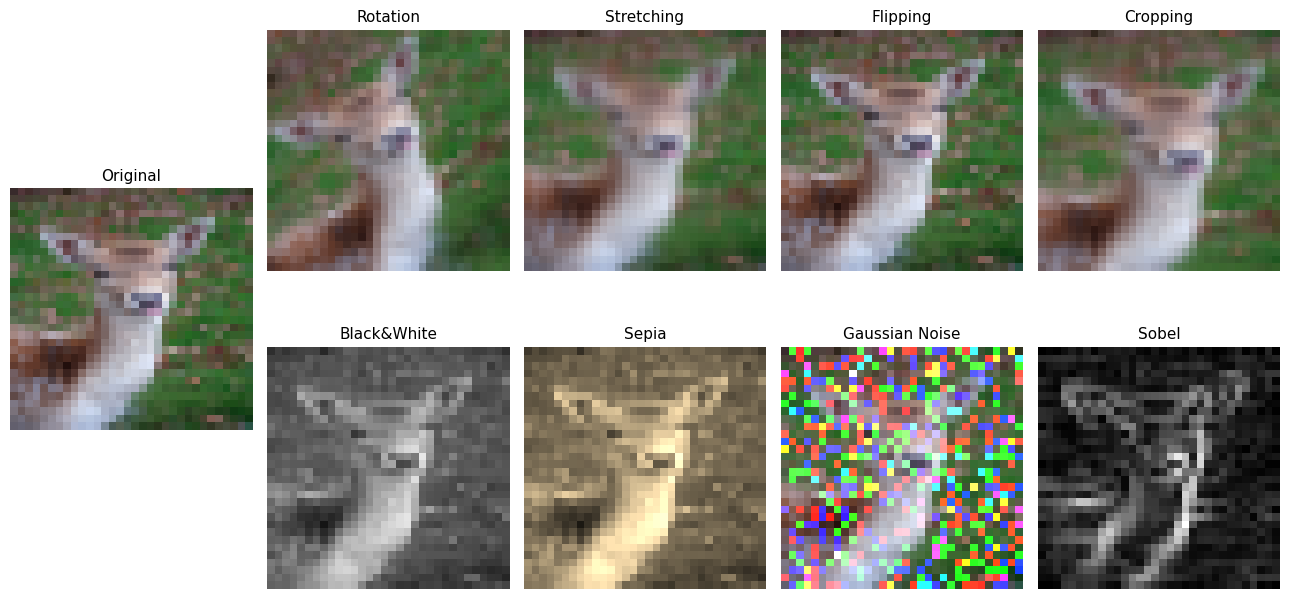

In [10]:
show_augmented_images(image)